In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Ler dados

In [2]:
# Acao Extensiva

df = pd.read_csv("data/AE_GO_RO.csv", low_memory=False)
df2 = pd.read_csv("data/AE_MS_SE.csv", low_memory=False)
df3 = pd.read_csv("data/AE_('ES','MA','PB', 'PE', 'RO', 'RR','SE', 'SG','TO', 'PI').csv", low_memory=False)
df = df.loc[df.DR=="RO"]

df = pd.concat([df, df2, df3])


df.drop_duplicates(inplace=True)

# Cursos
df_curso = pd.read_csv("data/Curso_GO_RO.csv")
df_curso2 = pd.read_csv("data/Curso_MS_SE.csv")
df_curso3 = pd.read_csv("data/Curso_('ES','MA','PB', 'PE', 'RO', 'RR','SE', 'SG','TO', 'PI').csv")
df_curso = pd.concat([df_curso, df_curso2, df_curso3])

df_curso.drop_duplicates(inplace=True)
# Uops

df_uop = pd.read_csv("data/UOP.csv")

df = df.merge(df_uop[["Codigo_Unidade", "codigo_ibge"]], left_on="Cod_Unidade",
             right_on="Codigo_Unidade", how="left")

for col in "Data_Nascimento", 'Data_Matricula', 'Data_Status_Matricula', 'Data_Inicio', 'Data_Fim': 
    df[col] = pd.to_datetime(df[col])
    
 

### Features Engineering

In [3]:
# Aluno matriculado em mais de um curso?

mat_alunos = df.groupby(["Doc_Identificacao"]).nunique()["Cod_Curso_Senac"].reset_index()
mat_alunos.loc[mat_alunos["Cod_Curso_Senac"]>1, "multicurso"] = 1
mat_alunos.fillna(0, inplace=True)
#mat_alunos.sort_values("Cod_Curso_Senac", ascending=False)
df = df.merge(mat_alunos[["Doc_Identificacao", "multicurso"]], 
              on="Doc_Identificacao", how="left")

# Aluno matriculado no mesmo municipio da unidade

df.loc[df.Municipio_Residencia_Aluno==df.codigo_ibge ,"mesmomuni"] = 1
df['mesmomuni'].fillna(0, inplace=True)

### Criação de bins

In [4]:
df.dropna(subset=["Data_Nascimento"], inplace=True)

df["idade"] = np.round((datetime.now() - df["Data_Nascimento"])/np.timedelta64(1,"Y")).astype("int")
df = df.loc[df.idade<100]

df['bins_idade'] = pd.cut(x=df['idade'], bins=[0,14, 20, 25, 30,
                                          40, 50, 60, 100], 
                         labels=[0, 1,2,3,4,5,6,7])

df['bins_CH'] = pd.cut(x=df['Carga_Horaria_Turma'], bins=[-1, 0, 30, 100, 6000], 
                         labels=[0,1,2,3])
df['bins_CHE'] = pd.cut(x=df['Carga_Horaria_Estagio_Turma'], bins=[-1, 0, 200, 700, 3000], 
                         labels=[0, 1,2,3])

df['bins_CHE'].fillna(0, inplace=True)
df['bins_CHE'] = df['bins_CHE'].astype(int)
df['bins_CH'].fillna(0, inplace=True)
df['bins_CH'] = df['bins_CH'].astype(int)
df = df.loc[~df["idade"]<100]
df['bins_idade'] = df['bins_idade'].astype(int)

df.drop(['idade', 'Carga_Horaria_Turma','Carga_Horaria_Estagio_Turma'], axis=1, inplace=True)

### Coluna Evadido (target)

In [5]:
df.loc[df.Cod_Esp_Matricula==3, "evadido"] = 1
df["evadido"].fillna(0, inplace=True)

## EDA

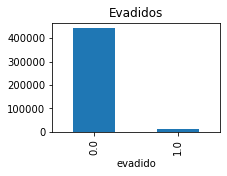

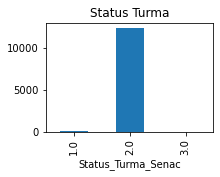

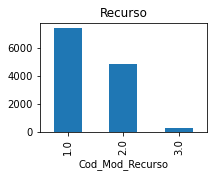

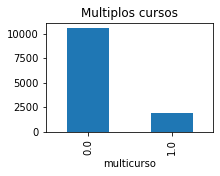

<AxesSubplot:title={'center':'Mesmo Muni'}, xlabel='mesmomuni'>

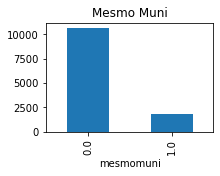

In [6]:
df.groupby("evadido")["Matricula_Apurada_Mes"].sum().plot(kind="bar", 
                                                          title="Evadidos",
                                                         figsize=(3,2))
plt.show()
df.loc[df.evadido==1].groupby("Status_Turma_Senac")["Matricula_Apurada_Mes"].\
sum().plot(kind="bar",title="Status Turma",figsize=(3,2))
plt.show()

df.loc[df.evadido==1].groupby("Cod_Mod_Recurso")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                            title="Recurso",
                                                                             figsize=(3,2))
plt.show()

df.loc[df.evadido==1].groupby("multicurso")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                            title="Multiplos cursos",
                                                                             figsize=(3,2))


plt.show()

df.loc[df.evadido==1].groupby("mesmomuni")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                           title="Mesmo Muni",
                                                                           figsize=(3,2))


In [38]:
df = df.loc[df.Status_Turma_Senac==2]

### Merge com cursos

In [7]:
df = df[["DR", 'Cod_Curso_Senac', 'Tipo_Ensino',
         'Cod_Mod_Recurso', 'Cod_Origem', 'Cod_Nacionalidade','Atestado_Baixa_Renda', 'Sexo', 'Cod_Raca', 'Cod_Escolaridade',
           'Cod_Estado_Civil',  'Deficiencia', 'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
           'CursoId', "bins_idade", "bins_CH", "bins_CHE", 'multicurso','mesmomuni','evadido']]

df_curso = df_curso[["Id_Curso", 'Id_Eixo', 'Id_Modalidade', 'Id_TipoCurso','Regional']].drop_duplicates()
df_curso["Regional"] = df_curso["Regional"].str.strip()

df = df.merge(df_curso, left_on=["DR",  'Cod_Curso_Senac'],
             right_on=["Regional", "Id_Curso"], how="left")

df.drop(["DR", "Regional", "Id_Curso", "Cod_Curso_Senac"], axis=1, inplace=True)

1023307
Tipo_Ensino                   0
Cod_Mod_Recurso               0
Cod_Origem               161275
Cod_Nacionalidade             0
Atestado_Baixa_Renda          0
Sexo                          0
Cod_Raca                 208711
Cod_Escolaridade          97504
Cod_Estado_Civil         203213
Deficiencia                   0
Trabalha_Atualmente      449378
Cod_Renda_Familiar       456912
Contrato_Aprendizagem      8154
CursoId                       0
bins_idade                    0
bins_CH                       0
bins_CHE                      0
multicurso                    0
mesmomuni                     0
evadido                       0
Id_Eixo                       0
Id_Modalidade                 0
Id_TipoCurso                  0
dtype: int64
---------
% evadido 0.025335505376196978


<AxesSubplot:title={'center':'Evadidos turmas concluidas'}, xlabel='evadido'>

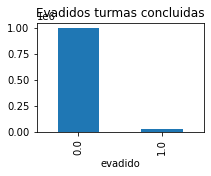

In [8]:
print(len(df))
print(df.isna().sum())
print("---------")
print("% evadido",len(df.loc[df.evadido==1])/len(df))
df.groupby("evadido")["Tipo_Ensino"].count().plot(kind="bar", 
                                                title="Evadidos turmas concluidas",
                                                figsize=(3,2))

### Columns selection

In [9]:
df = df[['Tipo_Ensino', 'Cod_Mod_Recurso', 'Sexo', 'Cod_Raca',
         'Cod_Escolaridade', 'Cod_Estado_Civil', 'Deficiencia',
         'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
         'bins_idade', 'bins_CH', 'bins_CHE', 'Id_Eixo',
         'Id_TipoCurso', "multicurso", "mesmomuni","evadido"]]

### Onehot

In [10]:
print(len(df))
df = df.dropna()
print(len(df))

1023307
507644


In [11]:
df_dum = pd.get_dummies(df, prefix=[c for c in df.columns[:-1]], 
                        columns = [c for c in df.columns[:-1]], 
                        drop_first=False)

In [12]:
print(len(df_dum.columns))
df_dum.columns

82


Index(['evadido', 'Tipo_Ensino_1.0', 'Tipo_Ensino_5.0', 'Tipo_Ensino_6.0',
       'Tipo_Ensino_7.0', 'Cod_Mod_Recurso_1.0', 'Cod_Mod_Recurso_2.0',
       'Cod_Mod_Recurso_3.0', 'Sexo_1.0', 'Sexo_2.0', 'Cod_Raca_1.0',
       'Cod_Raca_2.0', 'Cod_Raca_3.0', 'Cod_Raca_4.0', 'Cod_Raca_5.0',
       'Cod_Raca_6.0', 'Cod_Escolaridade_1.0', 'Cod_Escolaridade_2.0',
       'Cod_Escolaridade_3.0', 'Cod_Escolaridade_4.0', 'Cod_Escolaridade_5.0',
       'Cod_Escolaridade_6.0', 'Cod_Escolaridade_7.0', 'Cod_Escolaridade_8.0',
       'Cod_Escolaridade_9.0', 'Cod_Escolaridade_10.0', 'Cod_Estado_Civil_1.0',
       'Cod_Estado_Civil_2.0', 'Cod_Estado_Civil_3.0', 'Cod_Estado_Civil_4.0',
       'Cod_Estado_Civil_5.0', 'Deficiencia_0.0', 'Deficiencia_1.0',
       'Trabalha_Atualmente_0.0', 'Trabalha_Atualmente_1.0',
       'Cod_Renda_Familiar_1.0', 'Cod_Renda_Familiar_2.0',
       'Cod_Renda_Familiar_3.0', 'Cod_Renda_Familiar_4.0',
       'Cod_Renda_Familiar_5.0', 'Cod_Renda_Familiar_6.0',
       'Cod_Renda

## ML

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [14]:
_df = df_dum.dropna()

X = _df[[c for c in _df.columns[1:]]]
y = _df.evadido
print("% evadidos = ", (y[y==1].sum())/len(y))

% evadidos =  0.02697953684077818


In [15]:
_df["evadido"].value_counts()

0.0    493948
1.0     13696
Name: evadido, dtype: int64

## Resample

### Upsampling

In [20]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class 
df_majority = _df[(_df['evadido']==0)] 
df_minority = _df[(_df['evadido']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 62834, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [22]:
df_upsampled["evadido"].value_counts()

1.0    62834
0.0    62834
Name: evadido, dtype: int64

In [30]:
_df = df_upsampled.dropna()
X = _df[[c for c in _df.columns[1:]]]
y = _df.evadido
print("% evadidos = ", (y[y==1].sum())/len(y))

% evadidos =  0.5


#### Melhores variaveis com chi_square

In [31]:
f = 77
bestfeatures = SelectKBest(score_func=chi2, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score_chi']  #naming the dataframe columns

In [32]:
featureScores.sort_values("Score_chi", ascending=False)

,Specs,Score_chi
74,Id_TipoCurso_8,3076.745941
53,bins_CH_2,3047.384033
70,Id_TipoCurso_3,2830.448785
5,Cod_Mod_Recurso_2.0,2250.577277
52,bins_CH_1,2089.781641
...,...,...
28,Cod_Estado_Civil_4.0,1.029315
30,Deficiencia_0.0,0.666014
55,bins_CHE_0,0.478768
23,Cod_Escolaridade_9.0,0.220480


In [33]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.2)
sel.fit(X,y)

VarianceThreshold(threshold=0.2)

In [34]:
_X = pd.DataFrame({"feature":sel.feature_names_in_,"variancia":sel.variances_}).sort_values("variancia", 
                                                                                            ascending=False)
_X

,feature,variancia
35,Cod_Renda_Familiar_2.0,0.247283
61,Id_Eixo_3,0.242194
0,Tipo_Ensino_1.0,0.239616
2,Tipo_Ensino_6.0,0.237340
12,Cod_Raca_4.0,0.229534
...,...,...
27,Cod_Estado_Civil_3.0,0.001351
39,Cod_Renda_Familiar_6.0,0.001224
75,Id_TipoCurso_9,0.001168
58,bins_CHE_3,0.000938


In [95]:
selected_X = _X.loc[_X.variancia>=0.2]['feature'].values

### Comparação de modelos default

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV

# X_ = X[selected_X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [20]:
model_pipeline = []
model_pipeline.append(LogisticRegression())
model_pipeline.append(SVC(probability=True))
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

In [53]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [39]:
model_list = ["Logistic Regression", "SVM", "KNN", 
              "Decision Tree", "Random Forest", "Naive Bayes"]
acc_list = []
auc_list = []
cm_list =[]
auc_rc_list= []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    pr, rc, _threshold = metrics.precision_recall_curve(y_test, y_prob[:,1])
    auc_rc_list.append(metrics.auc(rc, pr))

C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


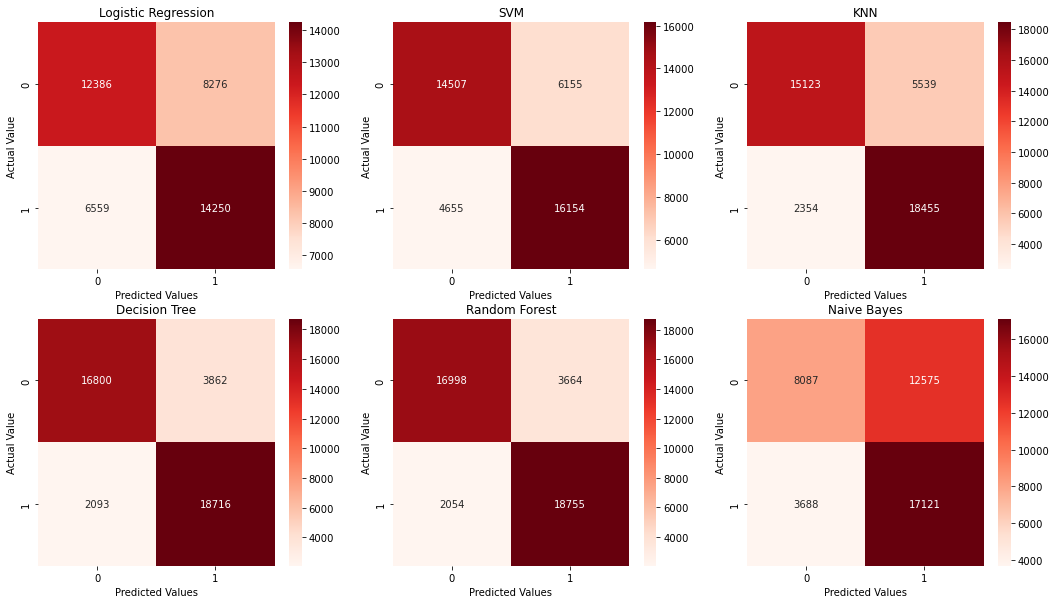

In [42]:
fig = plt.figure(figsize=(18,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2,3,i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")
    cm_plot.set_ylabel("Actual Value")
    cm_plot.set_xlabel("Predicted Values")

In [43]:
results_df = pd.DataFrame({"Model": model_list,
                          "Accuracy": acc_list,
                          "AUC": auc_list,"AUC_PR": auc_rc_list})
results_df.sort_values("Accuracy", ascending=False)

,Model,Accuracy,AUC,AUC_PR
4,Random Forest,0.862121,0.86,0.941019
3,Decision Tree,0.856406,0.86,0.927516
2,KNN,0.809674,0.81,0.895471
1,SVM,0.739336,0.74,0.787446
0,Logistic Regression,0.642280,0.64,0.694977
5,Naive Bayes,0.607846,0.61,0.651006


### Random Forest 

In [44]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [26]:
def criar_preds(y_pred):
    df_pred = pd.DataFrame(y_pred)
    df_pred["evadido"] = y_test.values
    return df_pred

def plotar_preds(df_pred, x=0.5):
    plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=30)
    plt.title("Prob de ser 0")
    plt.xlabel("Probabilidade do modelo")
    plt.ylabel("alunos não evadidos")
    plt.show()
    plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=30)
    plt.title("Prob de ser 1")
    plt.xlabel("Probabilidade do modelo")
    plt.ylabel("alunos evadidos")
    plt.vlines(x, 0, 100, 'r', '-')
    plt.show()
    
def criar_cm(df_pred, limite=0.2):
    
    df_pred = pd.DataFrame(y_pred)
    df_pred["evadido"] = y_test.values
    df_pred.loc[df_pred[1] > limite, "pred"] = 1
    df_pred.pred.fillna(0, inplace=True)
    df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==0), "res"] = "TN"
    df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==1), "res"] = "FN"
    df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==0), "res"] = "FP"
    df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==1), "res"] = "TP"
    cm = pd.DataFrame(df_pred.groupby("res").count()["pred"]).reset_index()
    
    return cm

def calcular_metricas(cm):
    recall = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FN"]["pred"].values)
    precision = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FP"]["pred"].values)
    f1 = (2 * precision * recall) / (precision + recall)
    return recall, precision, f1

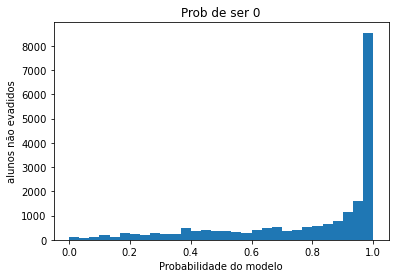

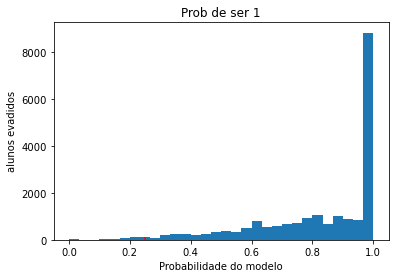

  res   pred
0  FN    182
1  FP   7403
2  TN  13259
3  TP  20627
[0.99125378] [0.73589012] [0.84469379]


In [46]:
df_pred = criar_preds(y_pred)
plotar_preds(df_pred, x=0.25)
cm = criar_cm(df_pred, limite=0.2)
print(cm)
recall, precision, f1 = calcular_metricas(cm)
print(recall, precision, f1)

### Logistic Regression

In [50]:
model = LogisticRegression(class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

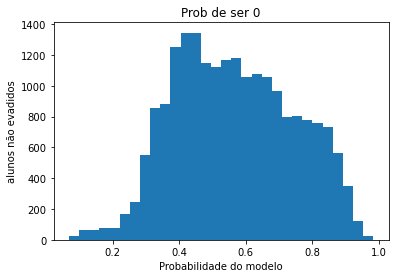

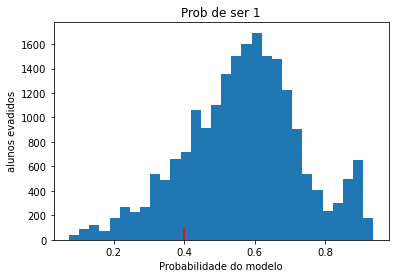

  res   pred
0  FN   3270
1  FP  12047
2  TN   8615
3  TP  17539


(array([0.84285646]), array([0.59281417]), array([0.69606112]))

In [51]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

df_pred = criar_preds(y_pred)
plotar_preds(df_pred, 0.4)

cm = criar_cm(df_pred, 0.4)
print(cm)
calcular_metricas(cm)

### SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(_df.drop('evadido', axis=1), _df['evadido'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [49]:
oversampled["evadido"].value_counts()

1.0    62834
0.0    62834
Name: evadido, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

_df = oversampled.dropna()
X = _df[[c for c in _df.columns[1:]]]
y = _df.evadido
print("% evadidos = ", (y[y==1].sum())/len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

% evadidos =  0.5


In [22]:

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
model_pipeline = []
model_pipeline.append(LogisticRegression())
model_pipeline.append(RandomForestClassifier())

model_list = ["Logistic Regression",  
               "Random Forest"]
acc_list = []
auc_list = []
cm_list =[]
auc_rc_list= []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    pr, rc, _threshold = metrics.precision_recall_curve(y_test, y_prob[:,1])
    auc_rc_list.append(metrics.auc(rc, pr))

C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


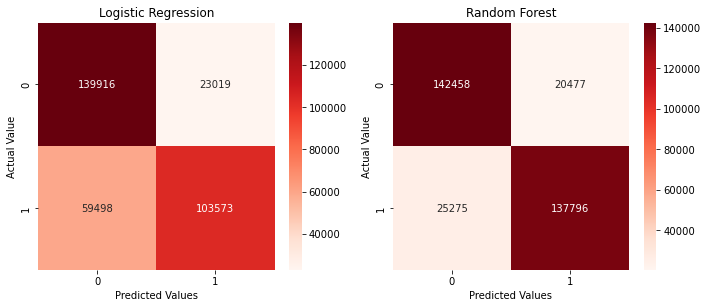

In [23]:
fig = plt.figure(figsize=(18,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2,3,i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")
    cm_plot.set_ylabel("Actual Value")
    cm_plot.set_xlabel("Predicted Values")

In [24]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

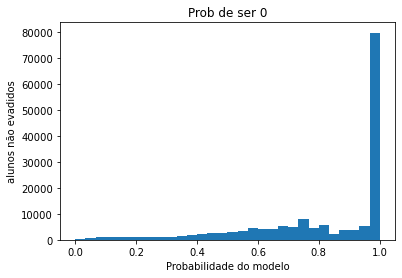

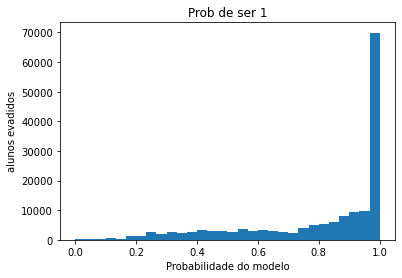

  res    pred
0  FN    5271
1  FP   53993
2  TN  108942
3  TP  157800
[0.96767666] [0.74506712] [0.84190533]


In [27]:
df_pred = criar_preds(y_pred)
plotar_preds(df_pred, x=0.25)
cm = criar_cm(df_pred, limite=0.25)
print(cm)
recall, precision, f1 = calcular_metricas(cm)
print(recall, precision, f1)

In [30]:
# random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# define model
#model = RandomForestClassifier(n_estimators=v10, class_weight='balanced_subsample')
model = BalancedRandomForestClassifier(n_estimators=50)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
#
output = cross_validate(model, X, y, cv=cv, scoring = 'roc_auc', return_estimator =True)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

MemoryError: Unable to allocate 50.9 MiB for an array with shape (81, 658597) and data type uint8